In [4]:
#VAE Code
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define the transform for the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# VAE model definition
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        # Decoder network
        self.decoder_fc = nn.Linear(latent_dim, 512)
        self.decoder_fc2 = nn.Linear(512, 128 * 16 * 16)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 16, 16)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Sigmoid to output values between 0 and 1
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = F.relu(self.decoder_fc(z))
        z = self.decoder_fc2(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function
def vae_loss(reconstructed_data, original_data, mu, logvar):
    MSE = F.mse_loss(reconstructed_data, original_data, reduction='sum')
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence loss
    return MSE + KL

# Function to train and save the model for a specific folder
def train_and_save_model(image_path, model_name, latent_dim=64, num_epochs=10):
    dataset = datasets.ImageFolder(root=image_path, transform=transform)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    vae = VAE(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)

    # Training Loop
    for epoch in range(num_epochs):
        vae.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)  # Move data to device

            optimizer.zero_grad()

            # Forward pass
            reconstructed_data, mu, logvar = vae(data)

            # Compute loss
            loss = vae_loss(reconstructed_data, data, mu, logvar)

            # Backpropagation
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(data_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")
    
    # Save the trained model
    model_save_path = f"{model_name}.pth"
    torch.save(vae.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

def generate_image_from_saved_model(label_str, latent_dim=64, device="cpu"):
    # Load the trained model for the specific label
    model_path = f"Trained model/vae_{label_str}.pth"
    if not os.path.exists(model_path):
        print(f"Unable to generate image.")
        return None

    vae = VAE(latent_dim=latent_dim).to(device)
    vae.load_state_dict(torch.load(model_path))
    vae.eval()

    # Generate a random latent vector
    latent_sample = torch.randn(1, latent_dim).to(device)

    # Generate image
    with torch.no_grad():
        generated_image = vae.decode(latent_sample).cpu()

    # Convert to numpy and display
    generated_image = generated_image.squeeze(0).permute(1, 2, 0).numpy()  # Change to HWC format
    generated_image = (generated_image * 255).astype('uint8')  # Convert to image format

    plt.imshow(generated_image)
    plt.axis('off')  # Hide axes
    plt.show()



In [6]:
def load_vae_model(model_name, model_path='vae_models/'):
    # Change the model path accordingly to where the you save the trained vae models
    model_file = os.path.join(model_path, f"{model_name}.pth")
    if not os.path.exists(model_file):
        raise FileNotFoundError(f"Model file '{model_name}.pth' not found.")

    # Extract the latent dimension from the model name (e.g., 'vae_64.pth' -> latent_dim=64)
    try:
        latent_dim = int(model_name.split('_')[-1])  # Get number after 'vae_'
    except ValueError:
        latent_dim = 64  # Default to 64 if it's not available in the filename

    # Load the VAE model with the inferred latent dimension
    vae = VAE(latent_dim=latent_dim)
    vae.load_state_dict(torch.load(model_file))
    vae.eval()  # Set the model to evaluation mode
    return vae

Epoch [1/10], Loss: 31593.3304
Epoch [2/10], Loss: 31379.9226
Epoch [3/10], Loss: 29750.6399
Epoch [4/10], Loss: 19542509.7143
Epoch [5/10], Loss: 24795.8452
Epoch [6/10], Loss: 23856.2723
Epoch [7/10], Loss: 22818.4702
Epoch [8/10], Loss: 21152.3185
Epoch [9/10], Loss: 19470.8586
Epoch [10/10], Loss: 18138.8601
Model saved to vae_Amazon_red_top.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


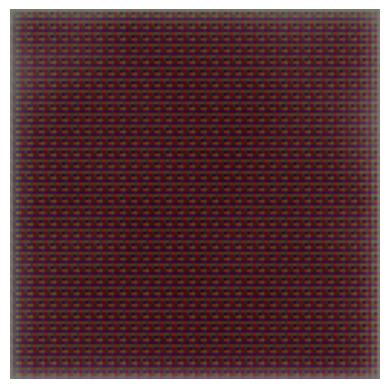

In [604]:
#Training with Amazon Red_Top_Data
train_and_save_model('resized_red_tops_images', "vae_Amazon_red_top")

generate_image_from_saved_model("Amazon_red_top")

Epoch [1/10], Loss: 36497.9208
Epoch [2/10], Loss: 36259.9167
Epoch [3/10], Loss: 35779.5083
Epoch [4/10], Loss: 34792.5917
Epoch [5/10], Loss: 31223.0271
Epoch [6/10], Loss: 23941.6188
Epoch [7/10], Loss: 28511.3042
Epoch [8/10], Loss: 18193.6688
Epoch [9/10], Loss: 16870.9573
Epoch [10/10], Loss: 16561.8646
Model saved to vae_Amazon_green_top.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


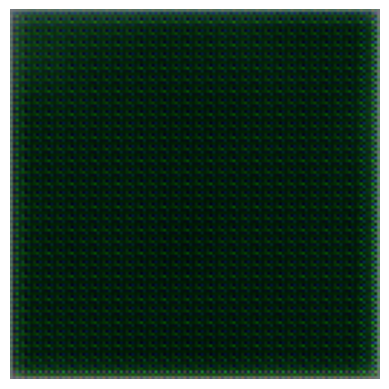

In [613]:
#Train VAE with Amazon Green_Top_Images
train_and_save_model('Resized_green_top_images', "vae_Amazon_green_top")

generate_image_from_saved_model("Amazon_green_top")

Epoch [1/10], Loss: 30386.3937
Epoch [2/10], Loss: 30074.9906
Epoch [3/10], Loss: 28964.9375
Epoch [4/10], Loss: 27270.3844
Epoch [5/10], Loss: 24825.6078
Epoch [6/10], Loss: 20261.5656
Epoch [7/10], Loss: 17669.6469
Epoch [8/10], Loss: 15759.3328
Epoch [9/10], Loss: 15616.9422
Epoch [10/10], Loss: 15396.5812
Model saved to vae_Amazon_blue_top.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


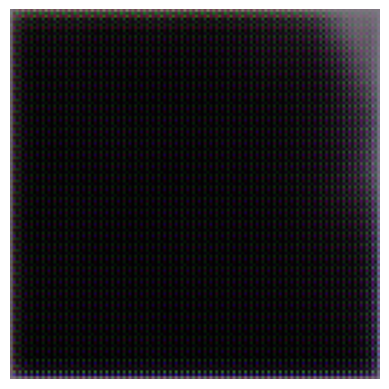

In [618]:
#Train VAE with Amazon Blue_Top_Images
train_and_save_model('Resized_blue_top_images', "vae_Amazon_blue_top")

generate_image_from_saved_model("Amazon_blue_top")

Epoch [1/10], Loss: 28537.0531
Epoch [2/10], Loss: 28444.9813
Epoch [3/10], Loss: 28224.1344
Epoch [4/10], Loss: 27179.8656
Epoch [5/10], Loss: 24164.5109
Epoch [6/10], Loss: 21556.2094
Epoch [7/10], Loss: 18103.5328
Epoch [8/10], Loss: 14628.9500
Epoch [9/10], Loss: 12468.0594
Epoch [10/10], Loss: 10852.9891
Model saved to vae_red_shirt.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


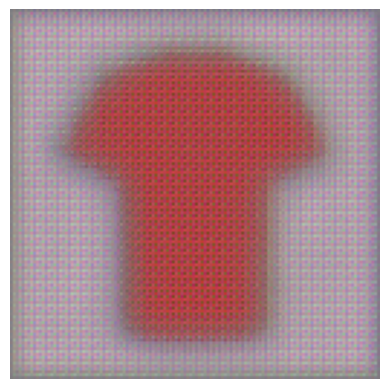

In [620]:
#Train VAE with mini_dataset of red shirts
train_and_save_model('resized_mini_dataset_images/red shirt', "vae_red_shirt")

generate_image_from_saved_model("red_shirt")

Epoch [1/10], Loss: 29835.7094
Epoch [2/10], Loss: 29584.3031
Epoch [3/10], Loss: 27893.1656
Epoch [4/10], Loss: 726771.5500
Epoch [5/10], Loss: 21158.2531
Epoch [6/10], Loss: 19883.4328
Epoch [7/10], Loss: 17645.8750
Epoch [8/10], Loss: 16083.7891
Epoch [9/10], Loss: 14672.9906
Epoch [10/10], Loss: 13541.2156
Model saved to vae_blue_shirt.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


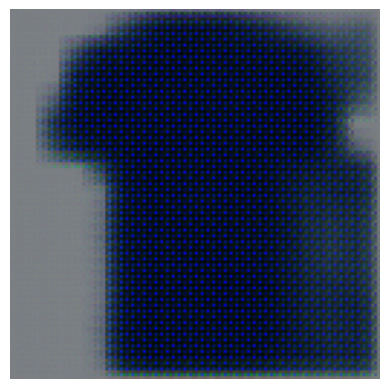

In [630]:
#Train VAE with mini_dataset of blue shirts
train_and_save_model('resized_mini_dataset_images/blue shirt', "vae_blue_shirt")

generate_image_from_saved_model("blue_shirt")

Epoch [1/10], Loss: 23625.0156
Epoch [2/10], Loss: 23472.8555
Epoch [3/10], Loss: 22507.7090
Epoch [4/10], Loss: 42161.7656
Epoch [5/10], Loss: 18895.9434
Epoch [6/10], Loss: 18012.5332
Epoch [7/10], Loss: 16957.9863
Epoch [8/10], Loss: 14748.9531
Epoch [9/10], Loss: 12495.0654
Epoch [10/10], Loss: 11411.4248
Model saved to vae_green_shirt.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


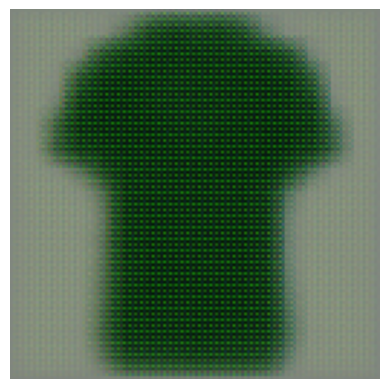

In [631]:
#Train VAE with mini_dataset of green shirts
train_and_save_model('resized_mini_dataset_images/green shirt', "vae_green_shirt")

generate_image_from_saved_model("green_shirt")

Epoch [1/10], Loss: 18078.0449
Epoch [2/10], Loss: 18002.9258
Epoch [3/10], Loss: 17867.7188
Epoch [4/10], Loss: 17641.5723
Epoch [5/10], Loss: 16925.3066
Epoch [6/10], Loss: 14661.6768
Epoch [7/10], Loss: 13457.6377
Epoch [8/10], Loss: 11385.0869
Epoch [9/10], Loss: 10165.8242
Epoch [10/10], Loss: 9179.4912
Model saved to vae_red_shirt_stripe.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


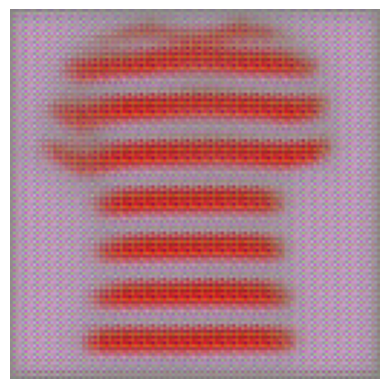

In [638]:
#Train VAE with mini_dataset of red shirts with stripes
train_and_save_model('resized_mini_dataset_images/red shirt with stripe', "vae_red_shirt_stripe")

generate_image_from_saved_model("red_shirt_stripe")

Epoch [1/10], Loss: 16267.3652
Epoch [2/10], Loss: 16169.4492
Epoch [3/10], Loss: 15992.3076
Epoch [4/10], Loss: 15492.5752
Epoch [5/10], Loss: 13718.2529
Epoch [6/10], Loss: 15185.2910
Epoch [7/10], Loss: 10701.3838
Epoch [8/10], Loss: 9972.4805
Epoch [9/10], Loss: 9332.3340
Epoch [10/10], Loss: 8406.0049
Model saved to vae_green_shirt_stripe.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


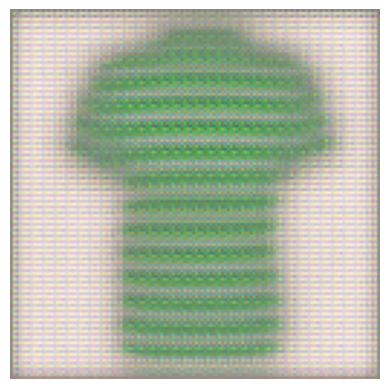

In [642]:
#Train VAE with mini_dataset of green shirts with stripes
train_and_save_model('resized_mini_dataset_images/green shirt with stripe', "vae_green_shirt_stripe")

generate_image_from_saved_model("green_shirt_stripe")

Epoch [1/10], Loss: 12921.2207
Epoch [2/10], Loss: 12800.6963
Epoch [3/10], Loss: 12391.8223
Epoch [4/10], Loss: 11872.3799
Epoch [5/10], Loss: 14396.8770
Epoch [6/10], Loss: 9905.8389
Epoch [7/10], Loss: 9476.2998
Epoch [8/10], Loss: 8760.8711
Epoch [9/10], Loss: 8049.2500
Epoch [10/10], Loss: 7197.8389
Model saved to vae_blue_shirt_stripe.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


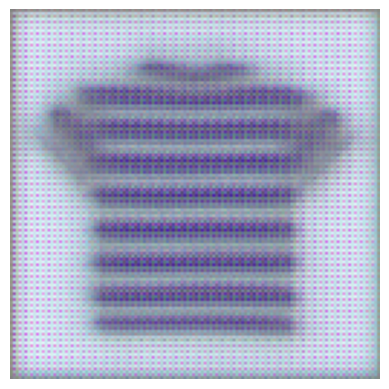

In [644]:
#Train VAE with mini_dataset of green shirts with stripes
train_and_save_model('resized_mini_dataset_images/blue shirt with stripe', "vae_blue_shirt_stripe")

generate_image_from_saved_model("blue_shirt_stripe")

Epoch [1/10], Loss: 17304.3301
Epoch [2/10], Loss: 17182.2500
Epoch [3/10], Loss: 16615.8066
Epoch [4/10], Loss: 16160.4941
Epoch [5/10], Loss: 14218.1377
Epoch [6/10], Loss: 13014.5127
Epoch [7/10], Loss: 11946.3447
Epoch [8/10], Loss: 10763.0088
Epoch [9/10], Loss: 9380.3525
Epoch [10/10], Loss: 8412.3857
Model saved to vae_red_shirt_checker.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


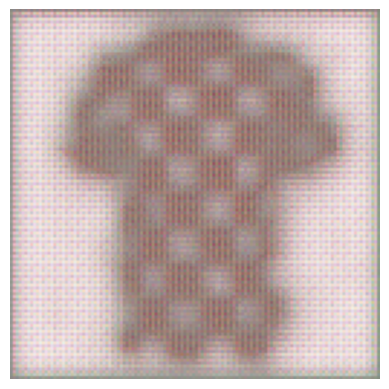

In [649]:
#Train VAE with mini_dataset of red shirts with checker
train_and_save_model('resized_mini_dataset_images/red shirt with checker', "vae_red_shirt_checker")

generate_image_from_saved_model("red_shirt_checker")

Epoch [1/10], Loss: 18678.0951
Epoch [2/10], Loss: 18645.2643
Epoch [3/10], Loss: 18570.9766
Epoch [4/10], Loss: 18442.4401
Epoch [5/10], Loss: 17995.2604
Epoch [6/10], Loss: 16656.5573
Epoch [7/10], Loss: 21430.7083
Epoch [8/10], Loss: 14190.7904
Epoch [9/10], Loss: 13990.0065
Epoch [10/10], Loss: 13758.1953
Model saved to vae_green_shirt_checker.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


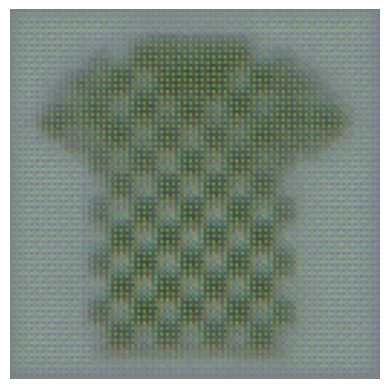

In [653]:
#Train VAE with mini_dataset of green shirts with checker
train_and_save_model('resized_mini_dataset_images/green shirt with checker', "vae_green_shirt_checker")

generate_image_from_saved_model("green_shirt_checker")

Epoch [1/10], Loss: 14015.8438
Epoch [2/10], Loss: 13965.3125
Epoch [3/10], Loss: 13831.8609
Epoch [4/10], Loss: 13617.4469
Epoch [5/10], Loss: 13198.6812
Epoch [6/10], Loss: 11770.9406
Epoch [7/10], Loss: 13932.3937
Epoch [8/10], Loss: 9353.2391
Epoch [9/10], Loss: 8828.2898
Epoch [10/10], Loss: 8215.8961
Model saved to vae_blue_shirt_checker.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


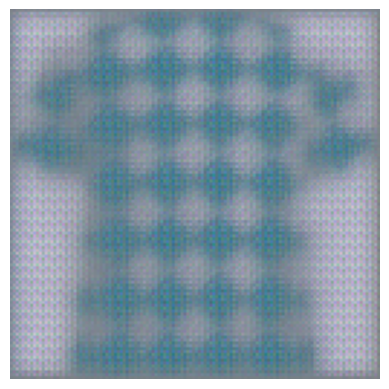

In [654]:
#Train VAE with mini_dataset of blue shirts with checker
train_and_save_model('resized_mini_dataset_images/blue shirt with checker', "vae_blue_shirt_checker")

generate_image_from_saved_model("blue_shirt_checker")

Epoch [1/10], Loss: 26134.8438
Epoch [2/10], Loss: 26032.4844
Epoch [3/10], Loss: 25853.2161
Epoch [4/10], Loss: 25392.8151
Epoch [5/10], Loss: 23995.4688
Epoch [6/10], Loss: 19371.0625
Epoch [7/10], Loss: 25328.6250
Epoch [8/10], Loss: 15294.7969
Epoch [9/10], Loss: 14352.1289
Epoch [10/10], Loss: 14078.8633
Model saved to vae_red_shirt_polka.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


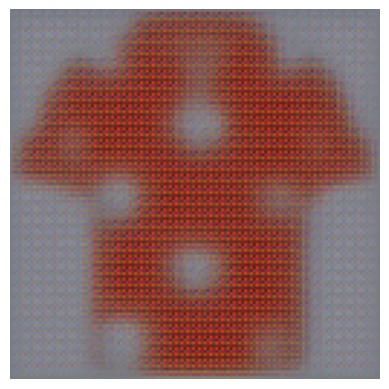

In [659]:
#Train VAE with mini_dataset of red shirts with polka dots
train_and_save_model('resized_mini_dataset_images/red shirt with polka', "vae_red_shirt_polka")

generate_image_from_saved_model("red_shirt_polka")

Epoch [1/10], Loss: 18655.4206
Epoch [2/10], Loss: 18602.6914
Epoch [3/10], Loss: 18496.6003
Epoch [4/10], Loss: 18112.5820
Epoch [5/10], Loss: 16987.1484
Epoch [6/10], Loss: 34800.8281
Epoch [7/10], Loss: 14196.1406
Epoch [8/10], Loss: 13469.4427
Epoch [9/10], Loss: 12893.6393
Epoch [10/10], Loss: 12238.2669
Model saved to vae_green_shirt_polka.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


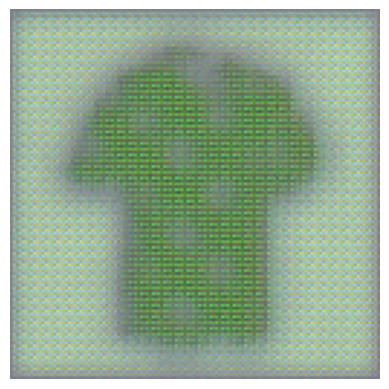

In [666]:
#Train VAE with mini_dataset of green shirts with polka dots
train_and_save_model('resized_mini_dataset_images/green shirt with polka', "vae_green_shirt_polka")

generate_image_from_saved_model("green_shirt_polka")

Epoch [1/10], Loss: 21262.3802
Epoch [2/10], Loss: 21188.4544
Epoch [3/10], Loss: 20979.1680
Epoch [4/10], Loss: 20041.8424
Epoch [5/10], Loss: 17276.1589
Epoch [6/10], Loss: 15274.1328
Epoch [7/10], Loss: 12391.6198
Epoch [8/10], Loss: 10639.0013
Epoch [9/10], Loss: 9444.9460
Epoch [10/10], Loss: 8567.7760
Model saved to vae_blue_shirt_polka.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


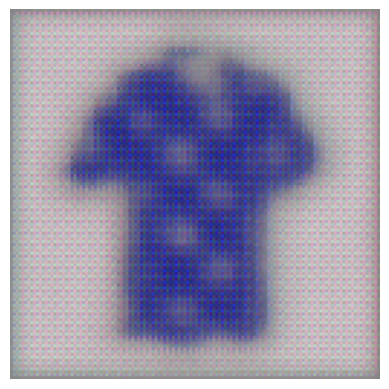

In [679]:
#Train VAE with mini_dataset of blue shirts with polka dots
train_and_save_model('resized_mini_dataset_images/blue shirt with polka', "vae_blue_shirt_polka")

generate_image_from_saved_model("blue_shirt_polka")

Epoch [1/10], Loss: 20701.1940
Epoch [2/10], Loss: 20620.2487
Epoch [3/10], Loss: 20414.3255
Epoch [4/10], Loss: 20073.4609
Epoch [5/10], Loss: 18530.3841
Epoch [6/10], Loss: 15604.1406
Epoch [7/10], Loss: 15631.3385
Epoch [8/10], Loss: 11657.5195
Epoch [9/10], Loss: 10523.7995
Epoch [10/10], Loss: 9111.6510
Model saved to vae_blue_pants.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


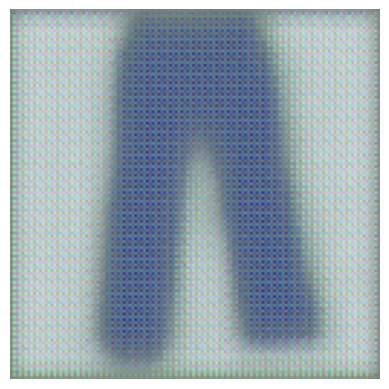

In [683]:
#Train VAE with mini_dataset of blue pants
train_and_save_model('resized_mini_dataset_images/blue pants', "vae_blue_pants")

generate_image_from_saved_model("blue_pants")

Epoch [1/10], Loss: 21664.2188
Epoch [2/10], Loss: 21620.5078
Epoch [3/10], Loss: 21468.9473
Epoch [4/10], Loss: 21102.7754
Epoch [5/10], Loss: 19677.0605
Epoch [6/10], Loss: 15606.1494
Epoch [7/10], Loss: 295722.2500
Epoch [8/10], Loss: 12018.8467
Epoch [9/10], Loss: 10467.9609
Epoch [10/10], Loss: 10634.6113
Model saved to vae_black_pants.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


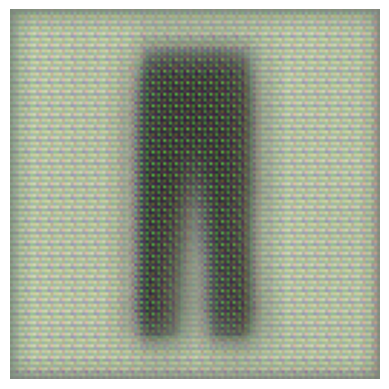

In [686]:
#Train VAE with mini_dataset of black pants
train_and_save_model('resized_mini_dataset_images/black pants', "vae_black_pants")

generate_image_from_saved_model("black_pants")

Epoch [1/10], Loss: 21035.7083
Epoch [2/10], Loss: 20943.5690
Epoch [3/10], Loss: 20726.0820
Epoch [4/10], Loss: 19802.3268
Epoch [5/10], Loss: 17502.8555
Epoch [6/10], Loss: 15613.2708
Epoch [7/10], Loss: 13986.3958
Epoch [8/10], Loss: 12161.5547
Epoch [9/10], Loss: 10410.8086
Epoch [10/10], Loss: 8826.1862
Model saved to vae_green_pants.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


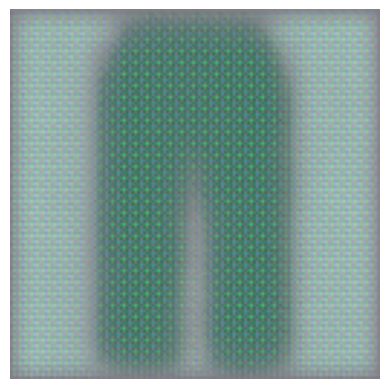

In [688]:
#Train VAE with mini_dataset of green pants
train_and_save_model('resized_mini_dataset_images/green pants', "vae_green_pants")

generate_image_from_saved_model("green_pants")

Epoch [1/10], Loss: 10968.2900
Epoch [2/10], Loss: 10919.6787
Epoch [3/10], Loss: 10806.2881
Epoch [4/10], Loss: 10635.5850
Epoch [5/10], Loss: 10305.2715
Epoch [6/10], Loss: 9403.5049
Epoch [7/10], Loss: 8053.1079
Epoch [8/10], Loss: 9883.7158
Epoch [9/10], Loss: 6487.1558
Epoch [10/10], Loss: 5727.2778
Model saved to vae_green_pants_stripe.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


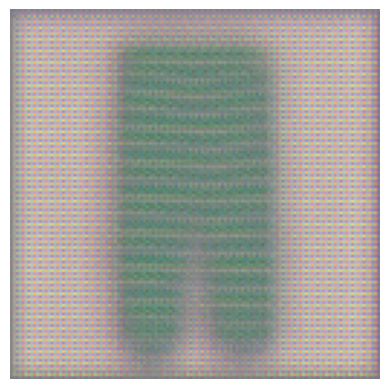

In [694]:
#Train VAE with mini_dataset of green pants with stripe
train_and_save_model('resized_mini_dataset_images/green pants with stripe', "vae_green_pants_stripe")

generate_image_from_saved_model("green_pants_stripe")

Epoch [1/10], Loss: 17985.7000
Epoch [2/10], Loss: 17904.1344
Epoch [3/10], Loss: 17717.4016
Epoch [4/10], Loss: 16701.0797
Epoch [5/10], Loss: 13643.6266
Epoch [6/10], Loss: 12416.9227
Epoch [7/10], Loss: 11005.1961
Epoch [8/10], Loss: 9740.2344
Epoch [9/10], Loss: 8597.2961
Epoch [10/10], Loss: 7752.9438
Model saved to vae_black_pants_stripe.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


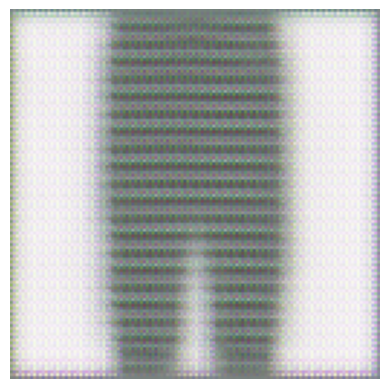

In [701]:
#Train VAE with mini_dataset of black pants with stripe
train_and_save_model('resized_mini_dataset_images/black pants with stripe', "vae_black_pants_stripe")

generate_image_from_saved_model("black_pants_stripe")

Epoch [1/10], Loss: 12910.8698
Epoch [2/10], Loss: 12850.3477
Epoch [3/10], Loss: 12759.9023
Epoch [4/10], Loss: 12599.3385
Epoch [5/10], Loss: 12202.9922
Epoch [6/10], Loss: 11272.8594
Epoch [7/10], Loss: 9357.7344
Epoch [8/10], Loss: 7862.8737
Epoch [9/10], Loss: 5934.8672
Epoch [10/10], Loss: 5172.3796
Model saved to vae_blue_pants_stripe.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


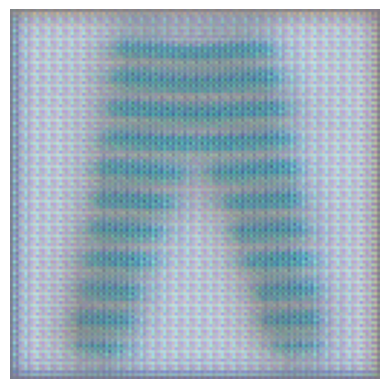

In [702]:
#Train VAE with mini_dataset of blue pants with stripe
train_and_save_model('resized_mini_dataset_images/blue pants with stripe', "vae_blue_pants_stripe")

generate_image_from_saved_model("blue_pants_stripe")

Epoch [1/10], Loss: 20144.5268
Epoch [2/10], Loss: 20063.8036
Epoch [3/10], Loss: 19924.3527
Epoch [4/10], Loss: 19662.3438
Epoch [5/10], Loss: 18960.8527
Epoch [6/10], Loss: 17217.4375
Epoch [7/10], Loss: 14816.4185
Epoch [8/10], Loss: 12755.8839
Epoch [9/10], Loss: 11391.7132
Epoch [10/10], Loss: 10552.5960
Model saved to vae_blue_pants_polka.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


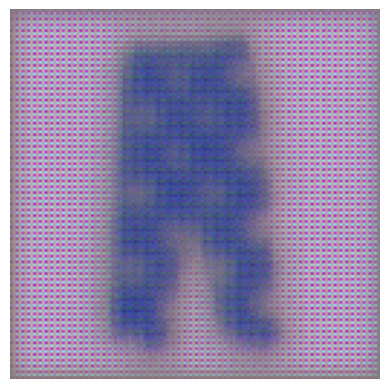

In [705]:
#Train VAE with mini_dataset of blue pants with polka
train_and_save_model('resized_mini_dataset_images/blue pants with polka', "vae_blue_pants_polka")

generate_image_from_saved_model("blue_pants_polka")

Epoch [1/10], Loss: 17339.3016
Epoch [2/10], Loss: 17215.1234
Epoch [3/10], Loss: 17026.1344
Epoch [4/10], Loss: 16548.4594
Epoch [5/10], Loss: 14581.4516
Epoch [6/10], Loss: 25711.1797
Epoch [7/10], Loss: 11053.9328
Epoch [8/10], Loss: 10270.7125
Epoch [9/10], Loss: 9259.3039
Epoch [10/10], Loss: 8516.5781
Model saved to vae_green_pants_polka.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


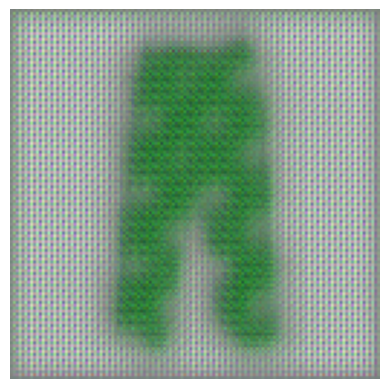

In [725]:
#Train VAE with mini_dataset of green pants with polka
train_and_save_model('resized_mini_dataset_images/green pants with polka', "vae_green_pants_polka")

generate_image_from_saved_model("green_pants_polka")

Epoch [1/10], Loss: 41567.0703
Epoch [2/10], Loss: 41422.0195
Epoch [3/10], Loss: 41205.5234
Epoch [4/10], Loss: 40578.5703
Epoch [5/10], Loss: 37834.0117
Epoch [6/10], Loss: 35691.3398
Epoch [7/10], Loss: 31360.8242
Epoch [8/10], Loss: 28625.9805
Epoch [9/10], Loss: 26104.6895
Epoch [10/10], Loss: 24258.4316
Model saved to vae_red_pants_polka.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\1081342902.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


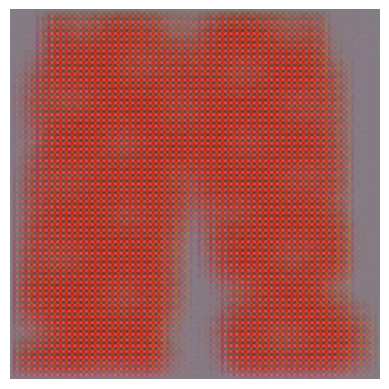

In [798]:
#Train VAE with mini_dataset of red pants with polka
train_and_save_model('resized_mini_dataset_images/red pants with polka', "vae_red_pants_polka")

generate_image_from_saved_model("red_pants_polka")

Epoch [1/10], Loss: 19938.0130
Epoch [2/10], Loss: 19839.2904
Epoch [3/10], Loss: 19390.2786
Epoch [4/10], Loss: 478039.9167
Epoch [5/10], Loss: 17240.6224
Epoch [6/10], Loss: 16814.8906
Epoch [7/10], Loss: 16197.8646
Epoch [8/10], Loss: 15469.6172
Epoch [9/10], Loss: 14547.9362
Epoch [10/10], Loss: 13251.9583
Model saved to vae_black_pants_checker.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


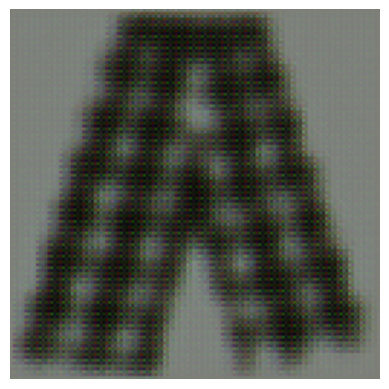

In [726]:
#Train VAE with mini_dataset of black pants with checker
train_and_save_model('resized_mini_dataset_images/black pants with checker', "vae_black_pants_checker")

generate_image_from_saved_model("black_pants_checker")

Epoch [1/10], Loss: 20958.2988
Epoch [2/10], Loss: 20826.7578
Epoch [3/10], Loss: 20299.8730
Epoch [4/10], Loss: 19586.9219
Epoch [5/10], Loss: 17212.8164
Epoch [6/10], Loss: 15702.8838
Epoch [7/10], Loss: 15030.8047
Epoch [8/10], Loss: 14367.2627
Epoch [9/10], Loss: 13904.1279
Epoch [10/10], Loss: 13353.4102
Model saved to vae_blue_pants_checker.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\765982245.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


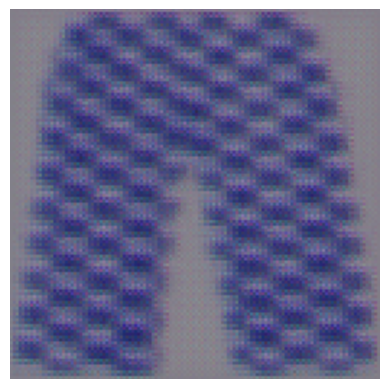

In [729]:
#Train VAE with mini_dataset of blue pants with checker
train_and_save_model('resized_mini_dataset_images/blue pants with checker', "vae_blue_pants_checker")

generate_image_from_saved_model("blue_pants_checker")

Epoch [1/10], Loss: 2730.4436
Epoch [2/10], Loss: 2694.5711
Epoch [3/10], Loss: 2626.2342
Epoch [4/10], Loss: 2500.8549
Epoch [5/10], Loss: 2232.8172
Epoch [6/10], Loss: 2012.4721
Epoch [7/10], Loss: 1733.5582
Epoch [8/10], Loss: 1554.9876
Epoch [9/10], Loss: 1451.5064
Epoch [10/10], Loss: 1372.6523
Model saved to vae_red_pants_checker.pth


C:\Users\rayau\AppData\Local\Temp\ipykernel_40532\1081342902.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(model_path))


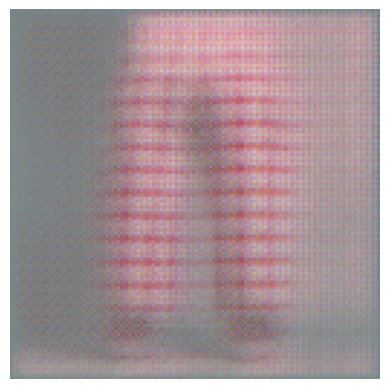

In [799]:
#Train VAE with mini_dataset of red pants with checker
train_and_save_model('resized_mini_dataset_images/red pants with checker', "vae_red_pants_checker")

generate_image_from_saved_model("red_pants_checker")